### Fundamental Matrix Estimation
[link to example](https://scikit-image.org/docs/stable/auto_examples/transform/plot_fundamental_matrix.html#sphx-glr-auto-examples-transform-plot-fundamental-matrix-py)

The example demonstrates how to robustly estimate *epipolar geometry* (the geometry of stereo vision) between two views using sparse ORB feature correspondences.

The fundamenatal matrix relates corresponding points between a pair of uncalibrated images. The matrix transforms homogenous image points in one image to epipolar lines in the other image.

Uncalibrated means that the intrinsic calibration (focal lengths, pixel skew, principal point) of the two cameras is not known. The fundamental matrix thus enables projective 3D reconstruction of the captured scene. If the calibration is known, estimated the essential matrix enables metric 3D reconstruction of the captured scene.

c:\Users\AdamSz\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Number od matches: 223
Number of inliers: 163


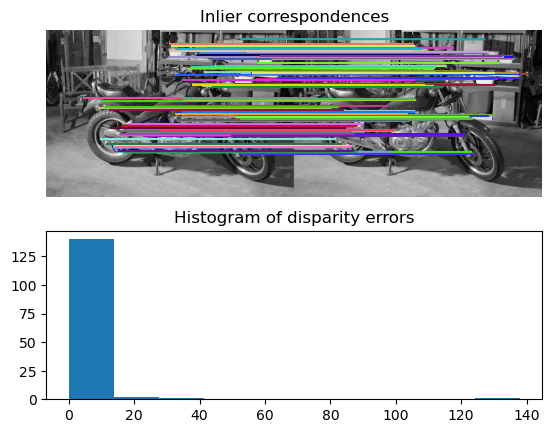

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform

image_left, image_right, groundtruth_disparities = data.stereo_motorcycle()
image_left, image_right = map(rgb2gray, (image_left, image_right))

# Find sparse feature correspondences between left and right image.
descriptor_extractor = ORB()

descriptor_extractor.detect_and_extract(image_left)
keypoints_left = descriptor_extractor.keypoints
descriptors_left = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(image_right)
keypoints_right = descriptor_extractor.keypoints
descriptors_right = descriptor_extractor.descriptors

matches = match_descriptors(descriptors_left, descriptors_right, cross_check=True)
print(f'Number od matches: {matches.shape[0]}')

# Estimate the epipolar geometry between the left and right image.
random_seed = 9
rng = np.random.default_rng(random_seed)

model, inliers = ransac(
    (keypoints_left[matches[:, 0]], keypoints_right[matches[:, 1]]),
    FundamentalMatrixTransform, min_samples=8, residual_threshold=1,
    max_trials=5000, random_state=rng
)

inlier_keypoints_left = keypoints_left[matches[inliers, 0]]
inlier_keypoints_right = keypoints_right[matches[inliers, 1]]

print(f'Number of inliers: {inliers.sum()}')

# Compare estimated sparse disparities to the dense ground-truth disparities.
disparities = inlier_keypoints_left[:, 1] - inlier_keypoints_right[:, 1]
disparities_coords = np.round(inlier_keypoints_left).astype(np.int64)
disparities_idxs = np.ravel_multi_index(disparities_coords.T, groundtruth_disparities.shape)
disparities_error = np.abs(groundtruth_disparities.ravel()[disparities_idxs] - disparities)
disparities_error = disparities_error[np.isfinite(disparities_error)]

# Visualize the results
fig, ax = plt.subplots(nrows=2, ncols=1)
plt.gray()

plot_matches(
    ax[0], image_left, image_right, keypoints_left, keypoints_right,
    matches[inliers], only_matches=True
)

ax[0].axis("off")
ax[0].set_title("Inlier correspondences")

ax[1].hist(disparities_error)
ax[1].set_title("Histogram of disparity errors")

plt.show()